In [19]:
import pandas as pd
import networkx as net
from collections import defaultdict
import math
import matplotlib.pyplot as plt
%matplotlib inline


In [20]:
df=pd.read_excel('follow.xlsx')
df.head()

,er,ee
0,2,1
1,3,1
2,4,1
3,5,1
4,6,13


In [21]:
group = df.groupby('ee').count()
group

,er
ee,
1,4
4,5
13,4
21,5
111,3


In [22]:
group2 = group.rename(columns={'er':'ct'})
group2

,ct
ee,
1,4
4,5
13,4
21,5
111,3


In [23]:
df.head()

,er,ee
0,2,1
1,3,1
2,4,1
3,5,1
4,6,13


In [24]:
df2=df.set_index('ee')

In [25]:
df2.head()

,er
ee,
1,2
1,3
1,4
1,5
13,6


In [26]:
to_save = df2.join(group2)
to_save

,er,ct
ee,,
1,2,4
1,3,4
1,4,4
1,5,4
4,99,5
4,88,5
4,77,5
4,133,5
4,73,5


In [27]:
to_save.to_csv('follow.csv')

In [28]:
follow = [ line.strip().split(',') for line in file('follow.csv') ]

In [29]:
data = follow[1:]
data[:5]

[['1', '2', '4'],
 ['1', '3', '4'],
 ['1', '4', '4'],
 ['1', '5', '4'],
 ['4', '99', '5']]

In [30]:
o = net.DiGraph()
hfollowers = defaultdict(lambda: 0)

In [31]:
for (twitter_user, followed_by, followers) in data:
    o.add_edge(twitter_user, followed_by, followers=int(followers))
    hfollowers[twitter_user] = int(followers)

In [32]:
hfollowers

defaultdict(<function __main__.<lambda>>,
            {'1': 4, '111': 3, '13': 4, '21': 5, '4': 5})

In [33]:
SEED = '1'

# centre around the SEED node and set radius of graph
g = net.DiGraph(net.ego_graph(o, SEED, radius=4))

def trim_degrees_ted(g, degree=1, ted_degree=1):
    g2 = g.copy()
    d = net.degree(g2)
    for n in g2.nodes():
        if n == SEED: continue # don't prune the SEED node
        if d[n] <= degree and not n.lower().startswith('1'):
            g2.remove_node(n)
        elif n.lower().startswith('1') and d[n] <= ted_degree:
            g2.remove_node(n)
    return g2

In [34]:
def trim_edges_ted(g, weight=1, ted_weight=10):
    g2 = net.DiGraph()
    for f, to, edata in g.edges_iter(data=True):
        if f == SEED or to == SEED: # keep edges that link to the SEED node
            g2.add_edge(f, to, edata)
        elif f.lower().startswith('1') or to.lower().startswith('1'):
            if edata['followers'] >= ted_weight:
                g2.add_edge(f, to, edata)
        elif edata['followers'] >= weight:
            g2.add_edge(f, to, edata)
    return g2

In [35]:
print 'g: ', len(g)
core = trim_degrees_ted(g, degree=235, ted_degree=1)
print 'core after node pruning: ', len(core)
core = trim_edges_ted(core, weight=250000, ted_weight=35000)
print 'core after edge pruning: ', len(core)

g:  10
core after node pruning:  1
core after edge pruning:  0


start_with_1 0
Not_1 0
colourmap:  {'start_with_1': 'red', 'Not_1': 'green'}


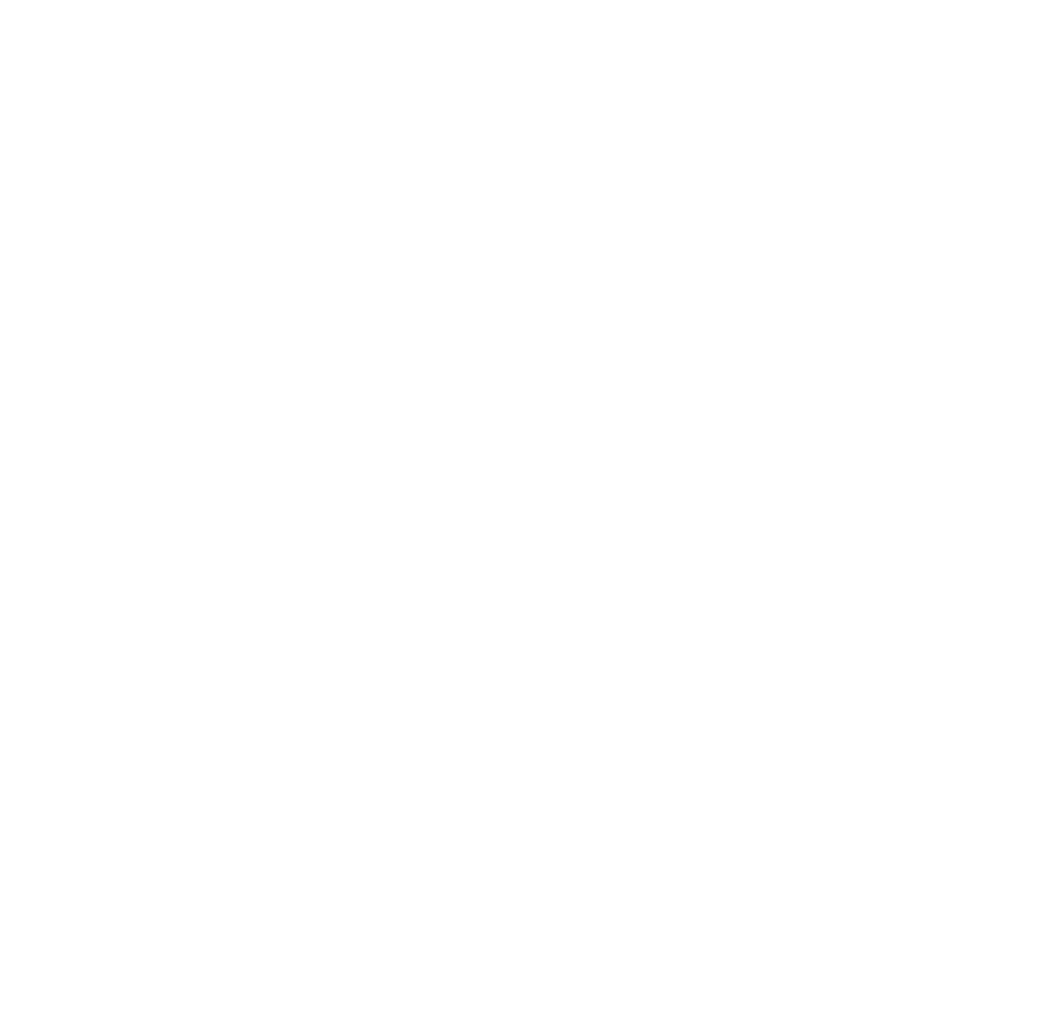

In [36]:
nodeset_types = { 'start_with_1': lambda s: s.lower().startswith('1'), 'Not_1': lambda s: not s.lower().startswith('1') }

nodesets = defaultdict(list)

for nodeset_typename, nodeset_test in nodeset_types.iteritems():
    nodesets[nodeset_typename] = [ n for n in core.nodes_iter() if nodeset_test(n) ]

pos = net.spring_layout(core) # compute layout

colours = ['red','green']
colourmap = {}

plt.figure(figsize=(18,18))
plt.axis('off')

# draw nodes
i = 0
alphas = {'start_with_1': 0.6, 'Not_1': 0.4}
for k in nodesets.keys():
    ns = [ math.log10(hfollowers[n]+1) * 80 for n in nodesets[k] ]
    print k, len(ns)
    net.draw_networkx_nodes(core, pos, nodelist=nodesets[k], node_size=ns, node_color=colours[i], alpha=alphas[k])
    colourmap[k] = colours[i]
    i += 1
print 'colourmap: ', colourmap

# draw edges
net.draw_networkx_edges(core, pos, width=0.5, alpha=0.5)

# draw labels
alphas = { 'start_with_1': 1.0, 'Not_1': 0.5}
for k in nodesets.keys():
    for n in nodesets[k]:
        x, y = pos[n]
        plt.text(x, y+0.02, s=n, alpha=alphas[k], horizontalalignment='center', fontsize=9)
        
